In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma

In [242]:
## EXTRACT THE RELEVANT SIMULATION PARAMETERS
param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_2"
with open(param_path + '/sim_params_simulation_study_2.json', 'r') as file:
    sim_params = json.load(file)

In [243]:
df_sim_params = pd.DataFrame(sim_params)
df_sim_params.columns = ['rate)matrices', 'rho_matrix', 'num_nodes', 'num_groups', 
                         'group_props', 'n_cavi', 'int_length', 'delta', 'T_max',
                         'change_steps_gap']

### Function for data extraction

In [245]:
def data_and_param_extract(idx, N_runs):
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_2/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)

    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)

    ## alpha
    gamma_list = []
    for j in range(N_runs):
        file_path = base_path + f"gamma/gamma_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        gamma_list.append(data)

    ## alpha
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

    ## changes
    changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"changes/changes_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        changes_list.append(data)

    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['gamma'] = gamma_list
    output_dict['tau'] = tau_list
    output_dict['changes'] = changes_list

    ## EXTRACT THE RELEVANT SIMULATION PARAMETERS
    param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_2"
    with open(param_path + '/sim_params_simulation_study_2.json', 'r') as file:
        sim_params = json.load(file)
        sim_params_curr = sim_params[idx]

    output_dict['rate_matrices'] = np.array(sim_params_curr[0])
    output_dict['rho_matrix'] = np.array(sim_params_curr[1])
    output_dict['num_nodes'] = int(sim_params_curr[2])
    output_dict['num_groups'] = int(sim_params_curr[3])
    output_dict['group_props'] = np.array(sim_params_curr[4])
    output_dict['n_cavi'] = int(sim_params_curr[5])
    output_dict['int_length'] = float(sim_params_curr[6])
    output_dict['delta'] = float(sim_params_curr[7])
    output_dict['T_max'] = float(sim_params_curr[8])
    output_dict['change_gap_steps'] = float(sim_params_curr[9])

    # Rate change times
    first_change = 3
    second_change = first_change + output_dict['change_gap_steps']  * output_dict['int_length'] 
    rate_change_times = np.array([first_change, second_change])
    output_dict['rate_change_times'] = rate_change_times

    ## CONSTRUCT TRUE GROUP LABELS
    group_sizes = (output_dict['group_props'] * output_dict['num_nodes']).astype('int')
    output_dict['group_sizes'] = group_sizes
    missing_nodes = output_dict['num_nodes'] - group_sizes.sum()
    if missing_nodes != 0:
        if np.sum(np.where(group_sizes == 0)) != 0:
            group_sizes[np.where(group_sizes == 0)] = missing_nodes
        else:
            group_sizes[-1] += missing_nodes
    true_groups = np.array(
                list(flatten([[i]*j for i,j in enumerate(group_sizes)]))
                )
    output_dict['groups'] = true_groups

    return output_dict


### Compute F1-score

In [6]:
df_rates = pd.DataFrame(columns=['num_nodes', 'group_1_prop', 
                               'delta', 'num_mem_changes', 'CCD',
                               'DNF', 'F1_score'], index=range(60))

def CCD_DNF_F1(flagged, true_changes):
    num_flagged = flagged.sum()
    num_flagged_true = np.minimum(flagged, true_changes).sum()
    num_true_changes = true_changes.sum()

    CCD = num_flagged_true / num_flagged
    DNF = num_flagged_true / num_true_changes

    F1_score = 2 * (CCD * DNF) / (CCD + DNF)

    return CCD, DNF, F1_score

for sim in range(60):
    data_dict = data_and_param_extract(sim)
    df_rates.loc[sim, ['num_nodes', 'group_1_prop', 'delta', 'num_mem_changes']] = (
        [data_dict['num_nodes'], data_dict['group_props'][0], data_dict['delta'], 
         data_dict['num_mem_changes']]
    )  
    changes_list = data_dict['changes'] 
    mem_change_times = data_dict['mem_change_times']
    _CCD_list = []
    _DNF_list = []
    _F1_score_list = []
    for run in range(50):
        flagged_change_times = changes_list[run][:,0] - data_dict['int_length'] / 2
        flagged_changes = changes_list[run][:,1]
        bins = np.arange(1, data_dict['T_max'], data_dict['int_length']) 
        true_changes, bin_edges = np.histogram(data_dict['mem_change_times'] + 10e-10, bins=bins)
        CCD, DNF, F1_score = CCD_DNF_F1(flagged_changes, true_changes)
        _CCD_list.append(CCD)
        _DNF_list.append(DNF)
        _F1_score_list.append(F1_score) 
    df_rates.loc[sim, 'CCD'] = _CCD_list
    df_rates.loc[sim, 'DNF'] = _DNF_list
    df_rates.loc[sim, 'F1_score'] = _F1_score_list

ValueError: operands could not be broadcast together with shapes (90,) (89,) 

Plot the posterior credible intervals of each component, along with the true value.

In [250]:
df_rates = pd.DataFrame(columns=['delta', 'first_change', 'second_change', 
                               'pred_change_times',
                               'conf_lower', 'conf_upper', 'mean'], index=range(12))

for sim in range(12):
    N_runs = 50
    data_dict = data_and_param_extract(sim, N_runs)
    df_rates.loc[sim, ['delta', 'first_change', 'second_change']] = (
        [data_dict['delta'], data_dict['rate_change_times'][0], 
         data_dict['rate_change_times'][1]]
    )
    alpha = np.array(data_dict['alpha'])
    beta = np.array(data_dict['beta'])
    gamma_dist = gamma(a = alpha, scale = 1 / beta)
    mean = gamma_dist.mean().mean(axis=0)
    lower = gamma_dist.ppf(0.025).mean(axis=0)
    upper = gamma_dist.ppf(0.975).mean(axis=0)

    df_rates.loc[sim, ['conf_lower', 'conf_upper', 'mean']] = lower, upper, mean

    df_rates.loc[sim,'pred_change_times'] = data_dict['changes']


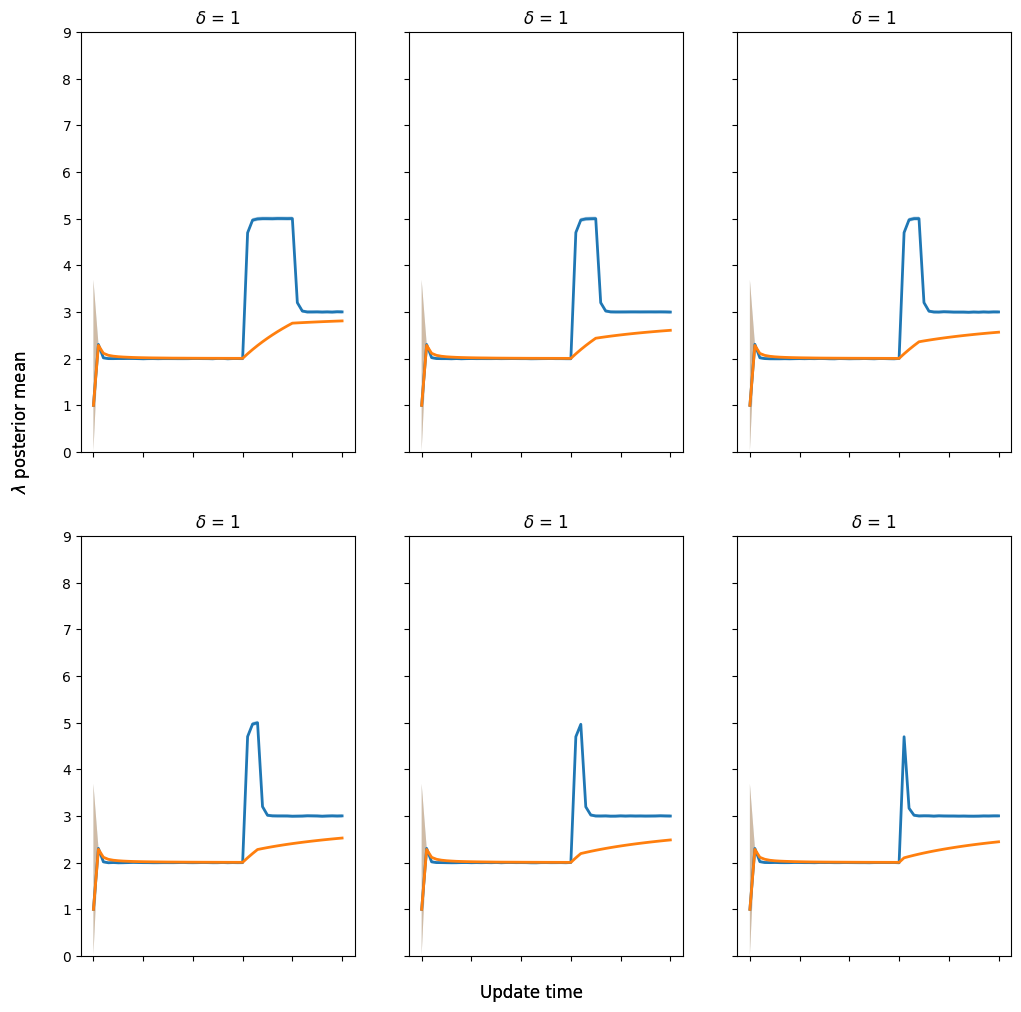

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(12, 12))

true_rates = data_dict['rate_matrices']
T_max = data_dict['T_max']
int_length = data_dict['int_length']

second_change = df_rates['second_change'].unique().reshape((2,3))

row_counter = -1
for i in range(2):
    for j in range(3):
        change_time = second_change[i,j]
        for delta in [0.1, 1]:
            index = df_rates[
                        (df_rates['delta'] == delta)
                        &
                        (df_rates['second_change'] == change_time)
                        ].index
            lower = df_rates.loc[index[0], 'conf_lower']
            upper = df_rates.loc[index[0], 'conf_upper']
            mean = df_rates.loc[index[0], 'mean']

            if delta == 0.1:
                for k in [1]:
                    for m in [1]:
                        axs[i,j].plot(np.arange(0, T_max + int_length, int_length), mean[:,k,m], linewidth=2)
                        axs[i,j].fill_between(np.arange(0, T_max + int_length, int_length), lower[:,k,m], upper[:,k,m], alpha=0.3)
                        # axs[i,j].axhline(true_rates[k,m], linestyle='--', color='black', linewidth=1)
                axs[i,j].set_title(fr"$\delta$ = {delta}", fontsize=12)
                if i != 2:
                    axs[i,j].set_xticklabels([])
                if j != 0:
                    axs[i,j].set_yticklabels([])
                axs[i,j].set_xlabel('')
                axs[i,j].set_ylabel('')
                axs[i,j].set_ylim([0,9])
            else:
                for k in [0]:
                    for m in [0]:
                        axs[i,j].plot(np.arange(0, T_max + int_length, int_length), mean[:,k,m], linewidth=2)
                        axs[i,j].fill_between(np.arange(0, T_max + int_length, int_length), lower[:,k,m], upper[:,k,m], alpha=0.3)
                        # axs[i,j].axhline(true_rates[k,m], linestyle='--', color='black', linewidth=1)
                axs[i,j].set_title(fr"$\delta$ = {delta}", fontsize=12)
                if i != 2:
                    axs[i,j].set_xticklabels([])
                if j != 0:
                    axs[i,j].set_yticklabels([])
                axs[i,j].set_xlabel('')
                axs[i,j].set_ylabel('')
                axs[i,j].set_ylim([0,9])


    fig.text(0.5, 0.075, 'Update time', ha='center', fontsize=12)
    fig.text(0.075, 0.5, r'$\lambda$ posterior mean', ha='center', rotation='vertical', fontsize=12)

# plt.savefig('analyses/simulation_studies/simulation_output/simulation_study_1/plots/stationary_process_lambda_posterior_0-1.pdf')

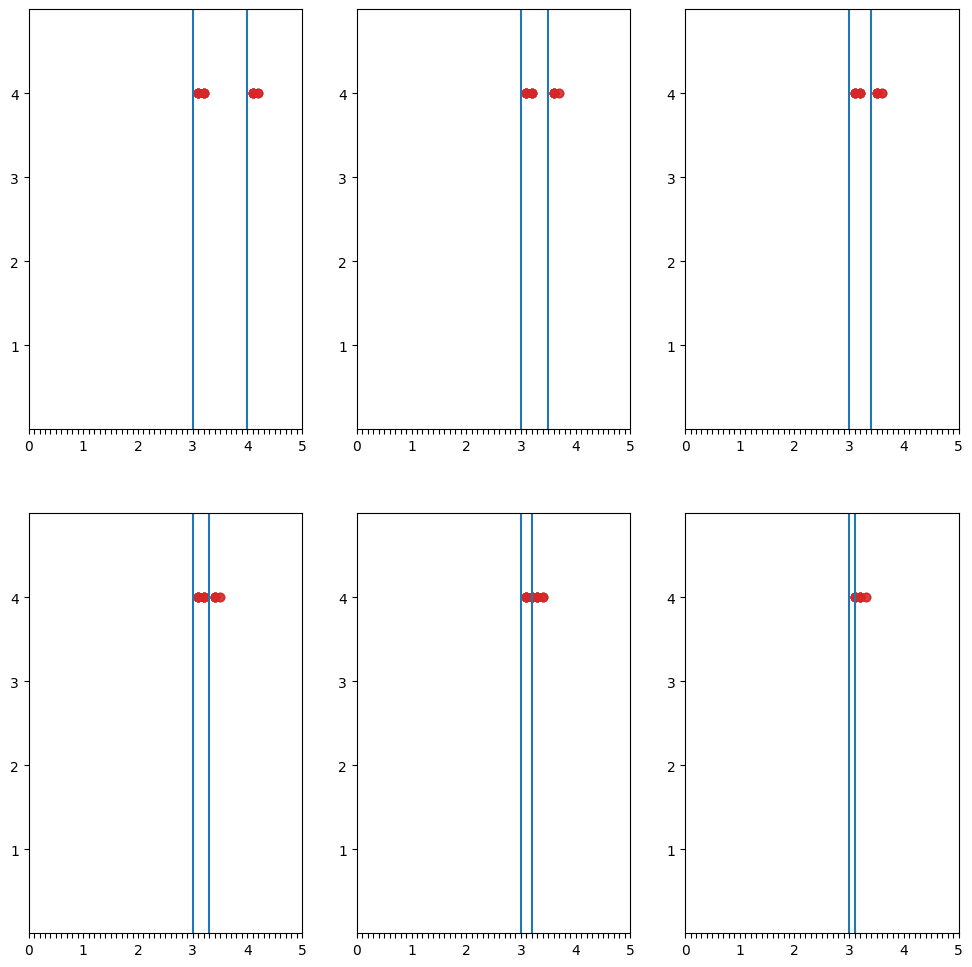

In [268]:
burn_in = 2

fig, axs = plt.subplots(2, 3, figsize=(12, 12))

T_max = data_dict['T_max']
int_length = data_dict['int_length']
second_change = df_rates['second_change'].unique().reshape((2,3))

for i in range(2):
    for j in range(3):
        change_time = second_change[i,j]
        for delta in [0.1]:
            index = df_rates[
                        (df_rates['delta'] == delta)
                        &
                        (df_rates['second_change'] == change_time)
                        ].index[0]
            pred_changes = np.concatenate(df_rates.loc[index, 'pred_change_times'])[:,[1,2,3]]
            if delta == 0.1:
                group_enum = 0
            else:
                group_enum = 5
            for k in range(2):
                for m in range(2):
                    if delta == 0.1:
                        group_enum += 1
                    else:
                        group_enum -= 1
                    group_k_m_changes = pred_changes[
                        (pred_changes[:,1] == k) & (pred_changes[:,2] == m)
                        ][:,0]
                    # Remove pre-burn in
                    group_k_m_changes = group_k_m_changes[group_k_m_changes > burn_in]
                    axs[i,j].plot(group_k_m_changes, 
                                np.tile(group_enum, len(group_k_m_changes)), 
                                'o', alpha=0.1)
            axs[i,j].axvline([df_rates.loc[index, 'first_change']])
            axs[i,j].axvline([df_rates.loc[index, 'second_change']])
            axs[i,j].set_xlim([1,5])
            axs[i,j].set_ylim([0,5])
            axs[i,j].set_yticks([1,2,3,4])
            axs[i,j].set_xticks(np.arange(0, T_max + int_length, int_length))
            integer_ticks = np.arange(0, T_max + int_length, 1)
            axs[i,j].set_xticklabels([str(int(x)) if x in integer_ticks else '' for x in np.arange(0, T_max + int_length, int_length)])
            


In [260]:
def CCD_DNF(cps, group_k_m_changes, burn_in=2):
    # Temporarily drop flags pre-burn in
    group_k_m_changes = group_k_m_changes[group_k_m_changes > burn_in]
    cp_prev = 0
    tot_detect = len(group_k_m_changes)
    true_flags = 0
    false_flags = 0
    for cp_num, cp in enumerate(cps):
        # First cp
        if cp_num == 0:
            in_region = group_k_m_changes[(group_k_m_changes <= cp)]
            false_flags += len(in_region)
        else:
            in_region = group_k_m_changes[(group_k_m_changes > cp_prev) & (group_k_m_changes <= cp)]
            if len(in_region) != 0:
                true_flags += 1
                false_flags += (len(in_region) - 1)
        cp_prev = cp
    
    # Final cp
    in_region = group_k_m_changes[(group_k_m_changes > cp)]
    if len(in_region) != 0:
        true_flags += 1
        false_flags += (len(in_region) - 1)

    # print(f"True flags: {true_flags}")
    # print(f"False flags: {false_flags}")
    # print(f"True changes: {cps}")
    # print(f"Pred changes: {group_k_m_changes}")
    if (true_flags + false_flags) != tot_detect:
        raise ValueError("Number of true or false flags incorrect.")
    
    CCD = true_flags / len(cps)
    DNF = true_flags / tot_detect

    return CCD, DNF

In [286]:
burn_in = 2

# fig, axs = plt.subplots(2, 3, figsize=(12, 12))

T_max = data_dict['T_max']
int_length = data_dict['int_length']
second_change = df_rates['second_change'].unique().reshape((2,3))

CCD_arr = np.zeros((2, 6, 50))
DNF_arr = np.zeros((2, 6, 50))
row_count = -1
for delta in [0.1, 1]:
    row_count += 1
    col_count = -1
    for i in range(2):
        for j in range(3):
            col_count += 1
            CCD_list = []; DNF_list = []
            change_time = second_change[i,j]
            index = df_rates[
                        (df_rates['delta'] == delta)
                        &
                        (df_rates['second_change'] == change_time)
                        ].index[0]
            pred_changes_list = df_rates.loc[index, 'pred_change_times']
            if delta == 0.1:
                group_enum = 0
            else:
                group_enum = 5
            for k in range(2):
                for m in range(2):
                    if delta == 0.1:
                        group_enum += 1
                    else:
                        group_enum -= 1
                    for ell in range(50):
                        pred_changes = pred_changes_list[ell][:,[0,2,3]]
                        group_k_m_changes = pred_changes[
                            (pred_changes[:,1] == k) & (pred_changes[:,2] == m)
                            ][:,0]
                        group_k_m_changes = group_k_m_changes[group_k_m_changes > burn_in]
                        if group_enum == 4:
                            CCD_val, DNF_val = CCD_DNF([3, change_time], group_k_m_changes,
                                                    burn_in)
                            CCD_list.append(CCD_val); DNF_list.append(DNF_val)
            if len(CCD_list) != 0:
                CCD_arr[row_count, col_count, :] = CCD_list
            if len(DNF_list) != 0:
                DNF_arr[row_count, col_count, :] = DNF_list

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5


In [330]:
((df_rates['second_change'].unique().astype('float') - 3) / 0.1).round().astype('int')

array([10,  5,  4,  3,  2,  1])

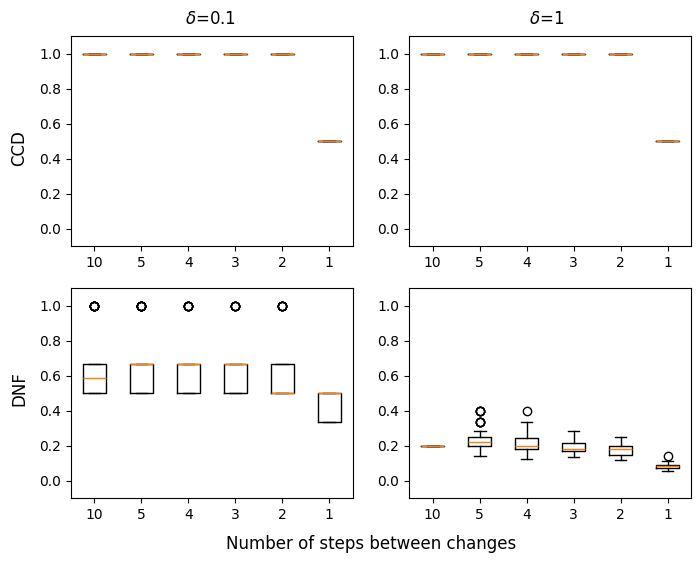

In [342]:
fig, axs = plt.subplots(2,2, figsize=(8,6))

gap_between_change = ((df_rates['second_change'].unique().astype('float') - 3) / 0.1).round().astype('int')

for i in range(2):
    for j in range(2):
        if i == 0:
            data = CCD_arr
        elif i == 1:
            data = DNF_arr
        axs[i,j].boxplot([data[j, gap, :] for gap in range(6)], positions=np.arange(6))
        axs[i,j].set_xticklabels(gap_between_change)
        axs[i,j].set_ylim([-0.1,1.1])


fig.text(0.06, 0.67, 'CCD', ha='center', rotation='vertical', fontsize=12)
fig.text(0.06, 0.27, 'DNF', ha='center', rotation='vertical', fontsize=12)
fig.text(0.3, 0.9, r'$\delta$=0.1', ha='center', fontsize=12)
fig.text(0.72, 0.9, r'$\delta$=1', ha='center', fontsize=12)
fig.text(0.5, 0.025, 'Number of steps between changes', ha='center', fontsize=12);

plt.savefig('analyses/simulation_studies/simulation_output/simulation_study_2/plots/CCD_DNF.pdf')

array([1. , 0.5, 0.4, 0.3, 0.2, 0.1])

In [267]:
DNF_arr

array([[[0.2       , 0.24086192, 0.21984749],
        [0.18943745, 0.18052571, 0.082856  ]]])

In [140]:
index = df_rates[
                (df_rates['delta'] == 0.1)
                &
                (df_rates['second_change'] == second_change[1,1])
                ].index[0]
np.concatenate(df_rates.loc[index,'pred_change_times'])[:,[1,2,3]]

array([[3.1, 1. , 1. ],
       [3.3, 1. , 1. ],
       [1.3, 0. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.4, 1. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [1.5, 0. , 1. ],
       [1.8, 0. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.4, 1. , 1. ],
       [1.3, 0. , 1. ],
       [1.4, 0. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.4, 1. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.4, 1. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.4, 1. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [3.4, 1. , 1. ],
       [3.1, 1. , 1. ],
       [3.2, 1. , 1. ],
       [3.3, 1. , 1. ],
       [1.4, 1. , 0. ],
       [3.1, 1. 

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(12, 12))

true_rates = data_dict['rate_matrices']
T_max = data_dict['T_max']
int_length = data_dict['int_length']

second_change = df_rates['second_change'].unique().reshape((2,3))

row_counter = -1
for i in range(2):
    for j in range(3):
        change_time = second_change[i,j]
        for delta in [0.1, 1]:
            index = df_rates[
                        (df_rates['delta'] == delta)
                        &
                        (df_rates['second_change'] == change_time)
                        ].index
            lower = df_rates.loc[index[0], 'conf_lower']
            upper = df_rates.loc[index[0], 'conf_upper']
            mean = df_rates.loc[index[0], 'mean']

            if delta == 0.1:
                for k in [1]:
                    for m in [1]:
                        axs[i,j].plot(np.arange(0, T_max + int_length, int_length), mean[:,k,m], linewidth=2)
                        axs[i,j].fill_between(np.arange(0, T_max + int_length, int_length), lower[:,k,m], upper[:,k,m], alpha=0.3)
                        # axs[i,j].axhline(true_rates[k,m], linestyle='--', color='black', linewidth=1)
                axs[i,j].set_title(fr"$\delta$ = {delta}", fontsize=12)
                if i != 2:
                    axs[i,j].set_xticklabels([])
                if j != 0:
                    axs[i,j].set_yticklabels([])
                axs[i,j].set_xlabel('')
                axs[i,j].set_ylabel('')
                axs[i,j].set_ylim([0,9])
            else:
                for k in [0]:
                    for m in [0]:
                        axs[i,j].plot(np.arange(0, T_max + int_length, int_length), mean[:,k,m], linewidth=2)
                        axs[i,j].fill_between(np.arange(0, T_max + int_length, int_length), lower[:,k,m], upper[:,k,m], alpha=0.3)
                        # axs[i,j].axhline(true_rates[k,m], linestyle='--', color='black', linewidth=1)
                axs[i,j].set_title(fr"$\delta$ = {delta}", fontsize=12)
                if i != 2:
                    axs[i,j].set_xticklabels([])
                if j != 0:
                    axs[i,j].set_yticklabels([])
                axs[i,j].set_xlabel('')
                axs[i,j].set_ylabel('')
                axs[i,j].set_ylim([0,9])


    fig.text(0.5, 0.075, 'Update time', ha='center', fontsize=12)
    fig.text(0.075, 0.5, r'$\lambda$ posterior mean', ha='center', rotation='vertical', fontsize=12)

# plt.savefig('analyses/simulation_studies/simulation_output/simulation_study_1/plots/stationary_process_lambda_posterior_0-1.pdf')

[array([[3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ]]),
 array([[3.2, 3.1, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ]]),
 array([[3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ]]),
 array([[3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ],
        [4.3, 4.2, 1. , 1. ]]),
 array([[3.2, 3.1, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ]]),
 array([[1.6, 1.5, 0. , 0. ],
        [3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ],
        [4.3, 4.2, 1. , 1. ]]),
 array([[1.4, 1.3, 1. , 0. ],
        [3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ]]),
 array([[1.9, 1.8, 1. , 0. ],
        [3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ],
        [4.3, 4.2, 1. , 1. ]]),
 array([[3.2, 3.1, 1. , 1. ],
        [3.3, 3.2, 1. , 1. ],
        [4.2, 4.1, 1. , 1. ]]),
 array([[3.2, 3.1, 1. , 1. ],
        [4.2, 4.1, 1. 

Plot the group membership probability

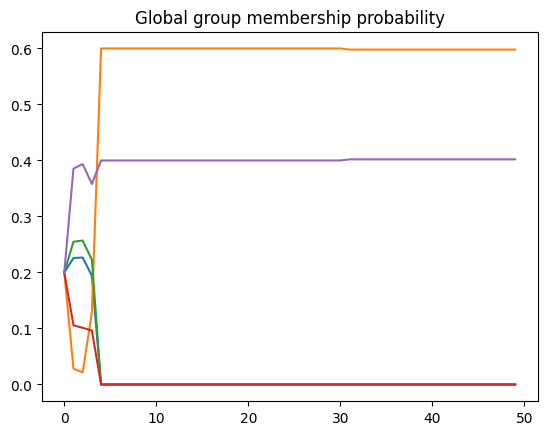

In [64]:
index = 26
tau_store = tau_list[index]
for i in range(tau_store.shape[2]):
    plt.plot(np.arange(T_max), tau_store[:,:,i].mean(axis=1))
plt.title("Global group membership probability")
plt.savefig("analyses/simulation_studies/global_prob_more_groups.png")

In [20]:
import numpy as np

# Assuming N, L are known
N = 4
L = 5

# Generate some example data for b
b = np.array([[1,2,3,13,14],
              [4,5,6,15,16],
              [7,8,9,17,18],
              [10,11,12,19,20]])

# Compute the sum without using for loops
# First, create a mask to select appropriate elements from b
mask = np.triu(np.ones((N, L), dtype=bool), k=1)

# Sum along the appropriate axes
sum_b = np.sum(b[:, np.newaxis, :] * mask[np.newaxis, :, :], axis=(2,))

# Compute the final result
a = np.sum(sum_b, axis=0)

a

array([188, 162, 132,  68])

In [24]:
nu = np.zeros((N,))
for j in range(N):
    for i in range(N):
        for k in range(j+1, L):
            nu[j] += b[i,k]
nu

array([188., 162., 132.,  68.])